## Demand for stationary storage in Europe: 1950--2050
Based on the [2020 impact assessment](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:52020SC0176) and the [2020 Study on energy storage](https://op.europa.eu/en/publication-detail/-/publication/a6eba083-932e-11ea-aac4-01aa75ed71a1), both by the European Commission.
Known points: no battery storage in 2015, 0.4GW in 2020, 20-40GW by 2030, and 50-120GW by 2050.
In 2018 in [A clean planet for all](https://ec.europa.eu/clima/sites/default/files/docs/pages/com_2018_733_analysis_in_support_en_0.pdf), the Commission expected 30GW by 2030 and 50-180GW by 2050.

Assumptions: logistic evolution, saturate in 2050.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# Load a local copy of the current ODYM branch:
import sys
import os
import pickle
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib
xlrd.xlsx.ensure_elementtree_imported(False, None)
xlrd.xlsx.Element_has_iter = True

In [3]:
# from logistic import logistic as logistic
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING)  
# For Ipython Notebook only
### Preamble
# Going to parent path
os.getcwd()
os.chdir("..")
os.chdir("..")

# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]


# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('EV_penetration_scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
NR = len(IndexTable.Classification[IndexTable.index.get_loc('Reuse_Scenarios')].Items)
NE = len(IndexTable.Classification[IndexTable.index.get_loc('Energy_Storage_Scenarios')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items)

INFO (3728079259.py <<module>>): ### 1. - Initialize.
INFO (3728079259.py <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 16. Check if all classifications are present. If yes, you are good to go!
INFO (3728079259.py <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (3728079259.py <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO

Vehicle stock model for European fleet


In [4]:
def evol_logistic(T_years, T0, y_max, T_mid, slope):
    y = pd.Series(data = np.zeros(len(T_years)), index = T_years)
    for T in 1 + np.arange(T0, T_years[-1]):
        y.loc[T] = y_max / (1 + np.exp(-slope*(T - T_mid)))
    return y

In [5]:
T_years = np.arange(1950, 2051)
df_GW = pd.DataFrame(index = T_years)
df_GW['Low'] = evol_logistic(T_years, T0 = 2016, y_max = 50, T_mid = 2030.75, slope = 0.5)
df_GW['Medium'] = evol_logistic(T_years, T0 = 2016, y_max = 85, T_mid = 2031.25, slope = 0.5)
df_GW['High'] = evol_logistic(T_years, T0 = 2016, y_max = 120, T_mid = 2031.4, slope = 0.5)
df_GW['CP4All'] = evol_logistic(T_years, T0 = 2016, y_max = 180, T_mid = 2034, slope = 0.4)
# Added by Fernando 22.11.2022
df_GW['ENTSOE_2022'] = evol_logistic(T_years, T0 = 2016, y_max = 250, T_mid = 2034, slope = 0.4)

## Creating numpy structured arrays for the model

In [6]:
DemandArray = np.zeros((NE,Nt)) # 3 Energy storage demand scenarios and 101 years.

In [7]:
# Bring data to machine readable form
df_GW_odym = df_GW.copy(deep = True)
df_GW_odym.reset_index(inplace=True)
df_GW_odym = df_GW_odym.melt('index')
df_GW_odym.head()

,index,variable,value
0,1950,Low,0.0
1,1951,Low,0.0
2,1952,Low,0.0
3,1953,Low,0.0
4,1954,Low,0.0


In [8]:
for m in range(0,len(df_GW_odym['value'])):
    try:
        ScenarioPosition = IndexTable.Classification[IndexTable.index.get_loc('Energy_Storage_Scenarios')].Items.index(df_GW_odym['variable'].iloc[m])
        TimePosition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(df_GW_odym['index'].iloc[m])
        DemandArray[ScenarioPosition, TimePosition] = df_GW_odym['value'].iloc[m] * 6 # We multiply the demand for power with a factor of 7 which is the mean discharge time expected by the EU
    # Some scenarios are not included in teh model run
    except ValueError:
        pass

In [16]:
DemandArray.shape

(3, 101)

## Exporting results

In [10]:
# define results path
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')
# Save as excel for overview
df_GW_odym.to_excel(results_path+'/Energy_storage_demand.xlsx')
# Saving array
np.save(results_path+'/Energy_storage_demand', DemandArray, allow_pickle=True)

### Plot and export to csv

In [11]:
df_GW.loc[2020]

Low            0.230479
Medium         0.305456
High           0.400177
CP4All         0.663163
ENTSOE_2022    0.921060
Name: 2020, dtype: float64

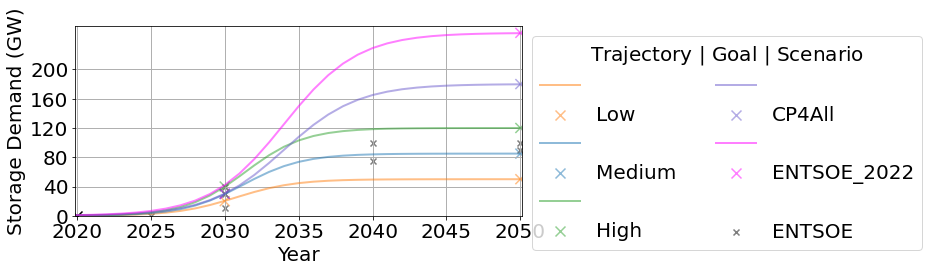

In [12]:
# layout
# rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
# rc('text', usetex=True)
fig = plt.figure(figsize=[8, 3.5], facecolor ='white')
plt.rcParams.update({'font.size': 20})
transp = 0.5
# plots
plt.scatter([2020], [0.4], s = [100], marker = 'x', color = 'Black')
# - low
plt.plot(df_GW['Low'], label = ' ', linewidth = 2, color = 'tab:orange', alpha = transp)
plt.scatter([2030, 2050], [20, 50], s = [100, 100], marker = 'x', label = 'Low   ', color = 'tab:orange', alpha = transp)
# - medium
plt.plot(df_GW['Medium'], label = ' ', linewidth = 2, color = 'tab:blue', alpha = transp)
plt.scatter([2030, 2050], [30, 85], s = [100, 100], marker = 'x', label = 'Medium', color = 'tab:blue', alpha = transp)
# - high
plt.plot(df_GW['High'], label = ' ', linewidth = 2, color = 'tab:green', alpha = transp)
plt.scatter([2030, 2050], [40, 120], s = [100, 100], marker = 'x', label = 'High', color = 'tab:green', alpha = transp)
# - very high
plt.plot(df_GW['CP4All'], label = ' ', linewidth = 2, color = 'slateblue', alpha = transp)
plt.scatter([2030, 2050], [30, 180], s = [100, 100], marker = 'x', label = 'CP4All', color = 'slateblue', alpha = transp)
# New ENTSOE scenario --> Added by Fernando
plt.plot(df_GW['ENTSOE_2022'], label = ' ', linewidth = 2, color = 'magenta', alpha = transp)
plt.scatter([2030, 2050], [30, 250], s = [100, 100], marker = 'x', label = 'ENTSOE_2022', color = 'magenta', alpha = transp)
# - ENTSOE
plt.plot([2025], [0], label = ' ', alpha = 0)
plt.scatter([2025, 2030, 2030, 2040, 2050, 2030, 2040, 2050], [0, 10, 40, 100, 100, 30, 75, 90], marker = 'x', label = 'ENTSOE', color = 'tab:gray')
# layout
plt.legend(loc = 'upper left', title = r'Trajectory $\vert$ Goal $\vert$ Scenario', ncol = 2, bbox_to_anchor=(1,1))
plt.grid(linewidth=1)
plt.xlabel('Year')
plt.ylabel('Storage Demand (GW)')
plt.xlim((2019.9, 2050.1))
# plt.xlim((2015, 2050))
plt.ylim((0, 260))
plt.yticks(np.arange(0, 220, 40))
fig.savefig('storage_demand_GW.pdf',bbox_inches='tight')
fig.savefig('storage_demand_GW.png',bbox_inches='tight', transparent=False)
# export to csv
df_GW.to_csv('storage_demand_GW.csv')
df_GW.to_excel('storage_demand_GW.xlsx')